In [167]:
# using QuantumToolbox
using OrdinaryDiffEq, LinearAlgebra
using PlotlyJS
using BenchmarkTools

# Non-linear Hamiltonian simulation

We put our theory to the test: a non-linear, generally non-diagonal $H_0$ with dissipation and a time-dependent drive. The model is given by
\begin{equation}
    H = \omega_r a^{\dagger} a + \omega_q b^{\dagger} b - K (b^{\dagger} + b)^4 - g (b^{\dagger} - b)(a^{\dagger} - a) + i\varepsilon_d(t) (a^{\dagger} - a)
\end{equation}
with corresponding typical values $\omega_r/2\pi = 7.5$ GHz, $\omega_q / 2\pi = 6.298$ GHz, $K/2\pi = 0.24$ GHz, $g/2\pi = 0.12$ GHz and driving frequencies $\omega_d / 2\pi = 7.515$ GHz, all for negative detuning $\Delta = \omega_q - \omega_r = -1.202$ GHz.

We can begin by looking only at the transmon, taking the coupling term as an effective drive and replacing $a,a^{\dagger}$ with $\alpha$, the classical coherent phase. Doing so yields an effective drive $\varepsilon_t(t) n_t = \frac{2g\varepsilon_d}{\kappa} (1 - e^{-\kappa t / 2}) \cos{\omega_d t} n_t$. We can also let the enveloppe be constant for now. We are ultimately just looking to gain intuition for these types of systems.


First, we define the parameters.

In [307]:
# parameters
const ωr = 2π * 7.5
const ωq = 2π * 6.298
const K = 2π * 0.24
const g = 2π * 0.12

const εd = 2π * 0.18
const ωd = 2π * 7.515

const κ = 2π * 0.03

# dimensions
const Nq = 15
const Nr = 5;


In [308]:
# operators
const b = diagm(1 => sqrt.(1:Nq-1));

In [327]:
function get_H_transmon()
    H = ωq * b' * b - K * (b' + b)^4
    return H
end

drive_op =  1im * (b' - b)
function get_H_drive(t)
    return 2*g*εd/κ * (1 - exp(-κ * t / 2)) * cos(ωd * t)
end

function f(du, u, p, t)
    mul!(du, get_H_transmon(), u, -1im, false)
    mul!(du, get_H_drive(t), u, -1im, true)
end;

In [328]:
u0 = zeros(Complex{Float64}, Nq)
u0[1] = 1.

tspan = (0., 10.)

(0.0, 10.0)

In [329]:
prob = ODEProblem(f, u0, tspan)
sol = solve(prob, Tsit5());

In [330]:
ψ = sol.u
c0 = getindex.(sol.u, 1);

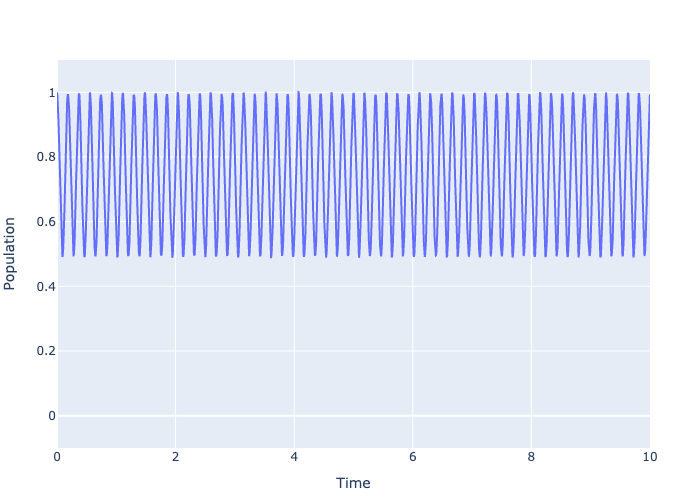

In [331]:
plot_effective = scatter(x = sol.t, y = abs2.(c0), mode = "lines", name = "real")

layout = Layout(yaxis_title="Population", xaxis_title="Time", yaxis_range=[-0.1, 1.1])

plot(plot_effective, layout)

In [333]:
@benchmark solve(prob, Tsit5())

BenchmarkTools.Trial: 13 samples with 1 evaluation.
 Range (min … max):  364.077 ms … 512.513 ms  ┊ GC (min … max): 17.49% … 39.50%
 Time  (median):     386.873 ms               ┊ GC (median):    19.97%
 Time  (mean ± σ):   397.326 ms ±  40.248 ms  ┊ GC (mean ± σ):  23.12% ±  6.31%

       █▃  █                                                     
  ▇▁▁▁▁██▁▁█▇▁▇▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▇▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▇ ▁
  364 ms           Histogram: frequency by time          513 ms <

 Memory estimate: 1.40 GiB, allocs estimate: 1123334.

Now, repeat the same problem by diagonalizing first.

In [334]:
# diagonalize the time-independent Hamiltonian
H0 = get_H_transmon()
values, vectors = eigen(H0)

# make U
U = vectors'

function rotate_matrix(H, U)
    return U * H * U'
end

H_transmon_rotated = rotate_matrix(get_H_transmon(), U)
drive_op_rotated = rotate_matrix(drive_op, U)

function f_rotated(du, u, p, t)
    mul!(du, H_transmon_rotated, u, -1im, false)
    mul!(du, drive_op_rotated, u, -1im * get_H_drive(t), true)
end;

In [335]:
prob_rotated = ODEProblem(f_rotated, u0, tspan, abstol=1e-7, reltol=1e-5)
sol_rot = solve(prob_rotated, Tsit5());

In [336]:
c0_rot = getindex.(sol_rot.u, 1);

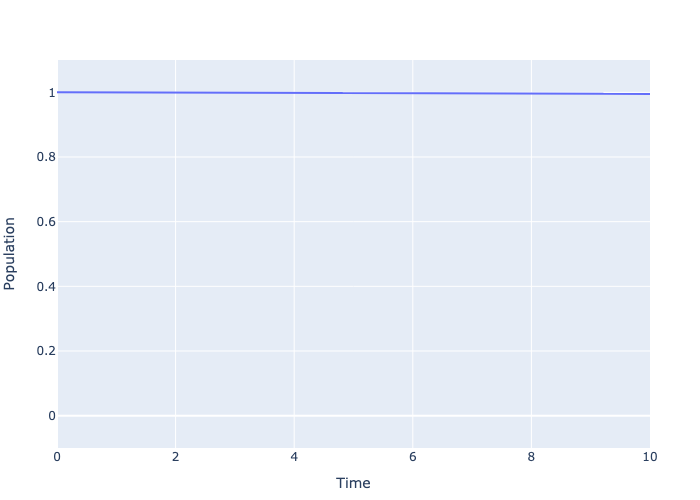

In [337]:
plot_rotated = scatter(x = sol_rot.t, y = abs2.(c0_rot), mode = "lines", name = "real")

layout = Layout(yaxis_title="Population", xaxis_title="Time", yaxis_range=[-0.1, 1.1])

plot(plot_rotated, layout)

In [298]:
@benchmark solve(prob_rotated, Tsit5())

BenchmarkTools.Trial: 39 samples with 1 evaluation.
 Range (min … max):  111.814 ms … 229.238 ms  ┊ GC (min … max): 0.00% … 49.12%
 Time  (median):     121.485 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   129.445 ms ±  21.030 ms  ┊ GC (mean ± σ):  9.66% ± 10.72%

   █▃         ▃                                                  
  ▄██▇▆▄▁▄▆▆▄▄█▄▄▁▁▁▄▄▁▁▄▁▁▁▁▁▁▁▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄ ▁
  112 ms           Histogram: frequency by time          229 ms <

 Memory estimate: 137.29 MiB, allocs estimate: 1260071.

Next, go into the interaction picture. This cancels the H_transmon term but with now make the operators `drive_op_rotated` time-dependent.

In [318]:
function f_interaction(du, u, p, t)
    mul!(du, exp(-1im * H_transmon_rotated * t) * drive_op_rotated * exp(1im * H_transmon_rotated * t), u, -1im * get_H_drive(t), false)
end;

In [319]:
prob_interaction = ODEProblem(f_interaction, u0, tspan, abstol=1e-7, reltol=1e-5)
sol_inter = solve(prob_interaction, Tsit5());

In [320]:
c0_inter = getindex.(sol_inter.u, 1);

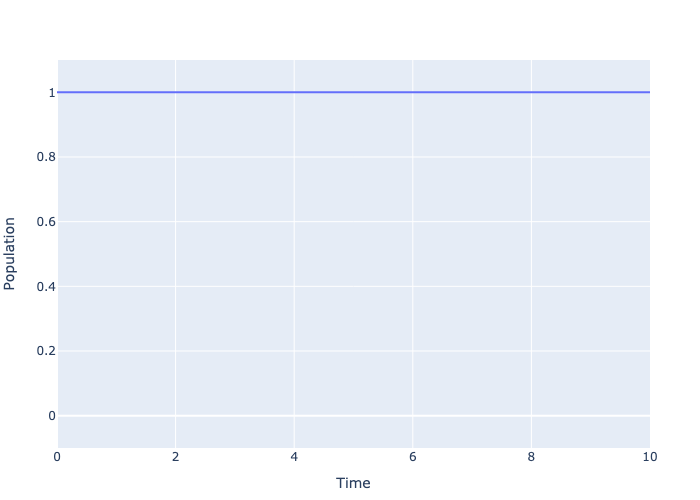

In [321]:
plot_interaction = scatter(x = sol_inter.t, y = abs2.(c0_inter), mode = "lines", name = "real")

layout = Layout(yaxis_title="Population", xaxis_title="Time", yaxis_range=[-0.1, 1.1])

plot(plot_interaction, layout)

In [ ]:
@benchmark solve(prob_interaction, Tsit5())